# QuTiP example: Floquet formalism for dynamics and steadystates master

J.R. Johansson and P.D. Nation

For more information about QuTiP see [http://qutip.org](http://qutip.org)

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
from qutip import *
import time

## Floquet modes and quasi energies

Find the floquet modes at time 0 and quasi energies for a driven system and plot the floquet states/quasienergies for one period of the driving.


In [5]:
def hamiltonian_t(t, args):
    """ evaluate the hamiltonian at time t. """
    H0 = args['H0']
    H1 = args['H1']
    w  = args['w']

    return H0 + sin(w * t) * H1

def H1_coeff_t(t, args):
    return sin(args['w'] * t)

In [6]:
def qubit_integrate(delta, eps0_vec, A, omega, T, option=None):

    # Hamiltonian
    sx = sigmax()
    sz = sigmaz()
    sm = destroy(2)

    quasi_energies = np.zeros((len(eps0_vec), 2))
    f_gnd_prob     = np.zeros((len(eps0_vec), 2))
    wf_gnd_prob    = np.zeros((len(eps0_vec), 2))

    for idx, eps0 in enumerate(eps0_vec):

        H0 = - delta/2.0 * sx - eps0/2.0 * sz
        H1 = A/2.0 * sz
       
        # H = H0 + H1 * sin(w * t) in the 'list-string' format
        H = [H0, [H1, 'sin(w * t)']]
        Hargs = {'w': omega}
            
        # find the floquet modes
        f_modes,f_energies = floquet_modes(H, T, Hargs,options=option)

        quasi_energies[idx,:] = f_energies

        f_gnd_prob[idx, 0] = expect(sm.dag() * sm, f_modes[0])
        f_gnd_prob[idx, 1] = expect(sm.dag() * sm, f_modes[1])
   
    return quasi_energies, f_gnd_prob, wf_gnd_prob

In [7]:
delta = 0.2 * 2 * np.pi                        # qubit sigma_x coefficient
eps0  = np.linspace(-5.0, 5.0, 200) * 2 * np.pi# qubit sigma_z coefficient
A      = 2.0 * 2 * np.pi # drive amplitude
psi0   = basis(2,0)    # initial state
omega  = 1.0 * 2 * np.pi # driving frequency
T      = (2*np.pi)/omega  # driving period

In [8]:
start_time = time.time()
q_energies, f_gnd_prob, wf_gnd_prob = qubit_integrate(delta, eps0, A, omega, T)
print('dynamics: time elapsed = ' + str(time.time() - start_time))

dynamics: time elapsed = 4.828046083450317


#### Plot Floquet spectrum
One should keep in mind that the quasi-energies are uniquely defined up to multiples of $2\pi/T$. The spectrum is thus folded in what we can refer to as the first Briouillin, *i.e.* in the interval $[-\pi/T,\pi/T]$.

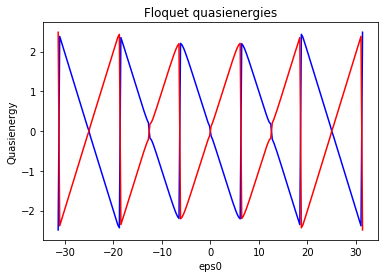

In [9]:
fig, ax = plt.subplots()
ax.plot(eps0, np.real(q_energies[:,0]) / delta, 'b',
        eps0, np.real(q_energies[:,1]) / delta, 'r')
ax.set_xlabel('eps0')
ax.set_ylabel('Quasienergy')
ax.set_title('Floquet quasienergies');

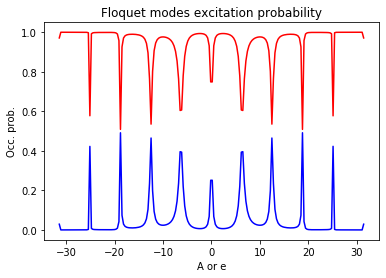

In [10]:
fig, ax = plt.subplots()
ax.plot(eps0, np.real(f_gnd_prob[:,0]), 'b', 
        eps0, np.real(f_gnd_prob[:,1]), 'r')
ax.set_xlabel('A or e')
ax.set_ylabel('Occ. prob.')
ax.set_title('Floquet modes excitation probability');

## Floquet modes time evolution

In [11]:
def hamiltonian_t(t, args):
    """ evaluate the hamiltonian at time t. """
    H0 = args[0]
    H1 = args[1]
    w  = args[2]

    return H0 + cos(w * t) * H1

def H1coeff_t(t, args):
    w  = args['w']
    return sin(w * t)           

In [12]:

def qubit_integrate(delta, eps0, A, omega, tlist, option=Options()):

    # Hamiltonian
    sx = sigmax()
    sz = sigmaz()
    sm = destroy(2)

    H0 = - delta/2.0 * sx - eps0/2.0 * sz
    H1 =   A/2.0 * sz
        
    #H_args = (H0, H1, omega)
    H_args = {'w': omega}
    H = [H0, [H1, 'sin(w * t)']]
    #H = [H0, [H1, H1coeff_t]]
    
    # find the propagator for one driving period
    T = 2*np.pi / omega
       
    f_modes_0,f_energies = floquet_modes(H, T, H_args, options=option)

    p_ex_0 = np.zeros(shape(tlist))
    p_ex_1 = np.zeros(shape(tlist))

    p_00 = np.zeros(shape(tlist), dtype=complex)
    p_01 = np.zeros(shape(tlist), dtype=complex)    
    p_10 = np.zeros(shape(tlist), dtype=complex)
    p_11 = np.zeros(shape(tlist), dtype=complex)    
    
    e_0 = np.zeros(shape(tlist))
    e_1 = np.zeros(shape(tlist))
         
    f_modes_table_t = floquet_modes_table(f_modes_0, f_energies, tlist, H, T, H_args, options=option) 

    for idx, t in enumerate(tlist):
        #f_modes_t = floquet_modes_t(f_modes_0, f_energies, t, H, T, H_args) 
        f_modes_t = floquet_modes_t_lookup(f_modes_table_t, t, T) 

        p_ex_0[idx] = expect(sm.dag() * sm, f_modes_t[0])
        p_ex_1[idx] = expect(sm.dag() * sm, f_modes_t[1])

        p_00[idx] = f_modes_t[0].full()[0][0]   # 0-th element of Floquet mode 0 
        p_01[idx] = f_modes_t[0].full()[1][0]   # 1st element of Floquet mode 0  
        p_10[idx] = f_modes_t[1].full()[0][0]   # 0-th element of Floquet mode 1
        p_11[idx] = f_modes_t[1].full()[1][0]   # 1st element of Floquet mode 1  

        #evals = hamiltonian_t(t, H_args).eigenenergies()
        evals = qobj_list_evaluate(H, t, H_args).eigenenergies()
        e_0[idx] = min(np.real(evals))
        e_1[idx] = max(np.real(evals))
        
    return p_ex_0, p_ex_1, e_0, e_1, f_energies, p_00, p_01, p_10, p_11

In [13]:
delta = 0.2 * 2 * np.pi  # qubit sigma_x coefficient
eps0  = 1.0 * 2 * np.pi  # qubit sigma_z coefficient
A     = 2.5 * 2 * np.pi  # sweep rate
omega  = 1.0 * 2 * np.pi # driving frequency
T      = (2*np.pi)/omega # driving period

tlist = np.linspace(0.0, T, 101)

In [14]:
start_time = time.time()
p_ex_0, p_ex_1, e_0, e_1, f_e, p_00, p_01, p_10, p_11 = qubit_integrate(delta, eps0, A, omega, tlist)
print('dynamics: time elapsed = ' + str(time.time() - start_time))

dynamics: time elapsed = 0.19188308715820312


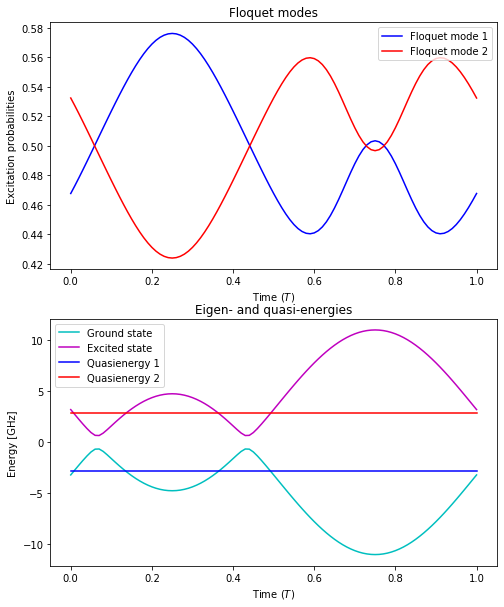

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[8,10])

ax1.plot(tlist, np.real(p_ex_0), 'b', tlist, np.real(p_ex_1), 'r')
ax1.set_xlabel('Time ($T$)')
ax1.set_ylabel('Excitation probabilities')
ax1.set_title('Floquet modes')
ax1.legend(("Floquet mode 1", "Floquet mode 2"))

ax2.plot(tlist, np.real(e_0), 'c', tlist, np.real(e_1), 'm')
ax2.plot(tlist, np.ones(shape(tlist)) * f_e[0], 'b', tlist, np.ones(shape(tlist)) * f_e[1], 'r')
ax2.set_xlabel('Time ($T$)')
ax2.set_ylabel('Energy [GHz]')
ax2.set_title('Eigen- and quasi-energies')
ax2.legend(("Ground state", "Excited state", "Quasienergy 1", "Quasienergy 2"));

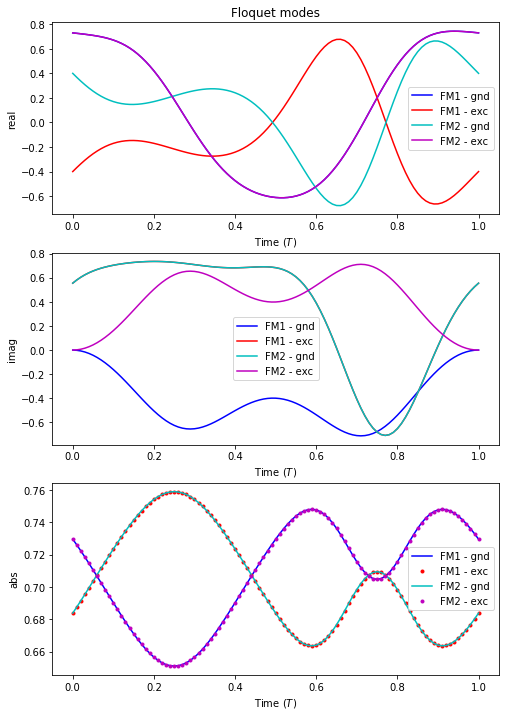

In [16]:
fig, axes = plt.subplots(3, 1, figsize=[8,12])

axes[0].plot(tlist, np.real(p_00), 'b', tlist, np.real(p_01), 'r')
axes[0].plot(tlist, np.real(p_10), 'c', tlist, np.real(p_11), 'm')
axes[0].set_xlabel('Time ($T$)')
axes[0].set_ylabel('real')
axes[0].set_title('Floquet modes')
axes[0].legend(("FM1 - gnd", "FM1 - exc", "FM2 - gnd", "FM2 - exc"))

axes[1].plot(tlist, np.imag(p_00), 'b', tlist, np.imag(p_01), 'r')
axes[1].plot(tlist, np.imag(p_10), 'c', tlist, np.imag(p_11), 'm')
axes[1].set_xlabel('Time ($T$)')
axes[1].set_ylabel('imag')
axes[1].legend(("FM1 - gnd", "FM1 - exc", "FM2 - gnd", "FM2 - exc"))

axes[2].plot(tlist, abs(p_00), 'b', tlist, abs(p_01), 'r.')
axes[2].plot(tlist, abs(p_10), 'c', tlist, abs(p_11), 'm.')
axes[2].set_xlabel('Time ($T$)')
axes[2].set_ylabel('abs')
axes[2].legend(("FM1 - gnd", "FM1 - exc", "FM2 - gnd", "FM2 - exc"));

## Floquet evolution

Find the floquet modes and quasi energies for a driven system and evolve the wavefunction "stroboscopically", i.e., only by evaluating at time mupliples of the driving period t = n * T for integer n.

The system is a strongly driven two-level atom.


In [17]:
def hamiltonian_t(t, args):
    """ evaluate the hamiltonian at time t. """
    H0 = args[0]
    H1 = args[1]
    w  = args[2]
    return H0 + np.sin(w * t) * H1
    
def H1coeff_t(t, args):
    w  = args['w']
    return np.sin(w * t)

In [18]:
def qubit_integrate(delta, eps0, A, omega, psi0, tlist, T, option, option_integrator=Options()):

    # Hamiltonian
    sx = sigmax()
    sz = sigmaz()
    sm = destroy(2)

    H0 = - delta/2.0 * sx - eps0/2.0 * sz
    H1 =   A/2.0 * sz        
    #H_args = (H0, H1, omega)
    H_args = {'w': omega}
    H = [H0, [H1, 'sin(w * t)']]
    #H = [H0, [H1, H1coeff_t]]  
    

    if option == "floquet":

        # find the floquet modes for the time-dependent hamiltonian        
        f_modes_0,f_energies = floquet_modes(H, T, H_args, options=option_integrator)

        # decompose the inital state in the floquet modes (=floquet states at t=0)
        f_coeff = floquet_state_decomposition(f_modes_0, f_energies, psi0)

                    
        # only evaluate the wavefunction at multiples of the driving period
        # i.e. a "stroboscopic" evolution
        N = int(max(tlist)/T)
        p_ex = np.zeros(N)                    
        tlist = []
        
        # calculate the wavefunctions at times t=nT, for integer n, by using 
        # the floquet modes and quasienergies
        for n in np.arange(N):            
            psi_t = Qobj(floquet_wavefunction_t(f_modes_0, f_energies, f_coeff, n*T, H, T,
                                           H_args, options=option_integrator))            
            p_ex[n] = expect(sm.dag() * sm, psi_t)
            tlist.append(n*T)   
    
    else:
    
        # for reference: evolve and calculate expectation using the full ode solver
        #H_args = (H0, H1, omega)
        #expt_list = mesolve(hamiltonian_t, psi0, tlist, [], [sm.dag() * sm], H_args)
        output = sesolve(H, psi0, tlist, [sm.dag() * sm], H_args, options=option_integrator)
        p_ex = output.expect[0]
        
    return tlist, p_ex

In [19]:
delta = 0.2 * 2 * np.pi  # qubit sigma_x coefficient
eps0  = 0.1 * 2 * np.pi  # qubit sigma_z coefficient
A     = 1.0 * 2 * np.pi  # driving amplitude
psi0   = basis(2,0)      # initial state
omega  = 1.0 * 2 * np.pi # driving frequency

T      = (2*np.pi)/omega # driving period
tlist  = np.linspace(0.0, 25 * T, 500)
option_integrator = Options(nsteps=1e17, atol=1.e-14, rtol=1.e-14, method='bdf', order=5)

In [20]:
start_time = time.time()
tlist1, p_ex = qubit_integrate(delta, eps0, A, omega, psi0, tlist, T, "dynamics", option_integrator)
print('dynamics: time elapsed = ' + str(time.time() - start_time))

dynamics: time elapsed = 0.24439406394958496


In [21]:
start_time = time.time()
tlist2, f_ex = qubit_integrate(delta, eps0, A, omega, psi0, tlist, T, "floquet", option_integrator)
print('floquet: time elapsed = ' + str(time.time() - start_time))

floquet: time elapsed = 0.032913923263549805


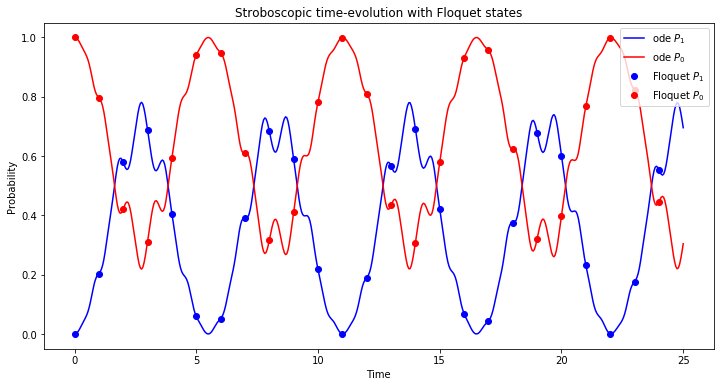

In [22]:
fig, ax = plt.subplots(figsize=[12, 6])
ax.plot(tlist1, np.real(p_ex),   'b')
ax.plot(tlist1, np.real(1-p_ex), 'r')
ax.plot(tlist2, np.real(f_ex),   'bo', linewidth=2.0)
ax.plot(tlist2, np.real(1-f_ex), 'ro', linewidth=2.0)

ax.set_xlabel('Time')
ax.set_ylabel('Probability')
ax.set_title('Stroboscopic time-evolution with Floquet states')
ax.legend(("ode $P_1$", "ode $P_0$", "Floquet $P_1$", "Floquet $P_0$"));

## Floquet-Markov master equation: comparison with other solvers

Notice that the Lindblad and Floquet-Markov master equation should perfectly agree when:

1) The drive is off and the dissipation on: A=0 and gamma$\neq$0

2) The drive is on and the dissipation off: A$\neq$0 and gamma=0

In [23]:
gamma = 0.015      # relaxation rate

def J_cb(omega):
    """ Noise spectral density """
    if omega>0:
        return 0.5 * gamma /(2*np.pi)
    else:
        return 0
    
def H1_coeff_t(t, args):
    return np.sin(args['w'] * t)

In [24]:
def qubit_integrate(delta, eps0, A, w, gamma, psi0, tlist, option=Options()):

    # Hamiltonian
    sx = sigmax()
    sz = sigmaz()
    sm = destroy(2)

    H0 = - delta/2.0 * sx - eps0/2.0 * sz
    H1 = - A * sx

    args = {'w': w}
    H = [H0, [H1, 'sin(w * t)']]

    # Build collapse operators for mesolve
    c_op_fmmesolve = sx
    
    eigenE, eigenS = H0.eigenstates()
    op0 = eigenS[0]*eigenS[0].dag()
    op1 = eigenS[1]*eigenS[1].dag()
    
    c_op_mesolve = []
    rate = np.zeros([2, 2], dtype=complex)
    for i in range(2):
        for j in range(2):
            if i != j:
                rate[i][j] = 2*np.pi*c_op_fmmesolve.matrix_element(
                    eigenS[j], eigenS[i])*c_op_fmmesolve.matrix_element(
                    eigenS[i], eigenS[j])*J_cb(eigenE[j]-eigenE[i])

    for i in range(2):
        for j in range(2):
            c_op_mesolve.append(np.sqrt(rate[i][j])*(eigenS[i]*eigenS[j].dag()))
         
    # --------------------------------------------------------------------------
    # 1) time-dependent hamiltonian
    # 
    #    
    e_ops = [sm.dag() * sm, sx, sz]
    
    start_time = time.time()
    output = mesolve(H, psi0, tlist, c_op_mesolve, e_ops, args=args, options=option)      
    expt_mesolve1 = [output.expect[k] for k in range(3)]
    print('Method 1: time elapsed = ' + str(time.time() - start_time))

    # --------------------------------------------------------------------------
    # 2) Constant hamiltonian
    #
    H_rwa = - delta/2.0 * sx - A * sx / 2
    
    start_time = time.time()
    output = mesolve(H_rwa, psi0, tlist, c_op_mesolve, e_ops, options=option)  
    expt_mesolve2 = [output.expect[k] for k in range(3)]
    print('Method 2: time elapsed = ' + str(time.time() - start_time))


    # --------------------------------------------------------------------------
    # 3) Floquet unitary evolution
    #
    qutip.solver.config.reset()
    
    start_time = time.time()
       
    T = 2*np.pi / w       
    f_modes_0, f_energies = floquet_modes(H, T, args, options=option)    
    
    # decompose the initial state vector in terms of the floquet modes (basis
    # transformation). used to calculate psi_t below.
    f_coeff = floquet_state_decomposition(f_modes_0, f_energies, psi0)
    
    # --------------------------------------------------------------------------
    # 4) Floquet markov master equation dynamics
    #       
    kmax = 1
    temp = 0
    w_th = temp * (1.38e-23 / 6.626e-34) * 2 * np.pi * 1e-9   
    
    f_modes_table_t = floquet_modes_table(f_modes_0, f_energies, np.linspace(0, T, 500+1),
                                          H, T, args, options=option) 
    
    # calculate the rate-matrices for the floquet-markov master equation
    Delta, X, Gamma, Amat = floquet_master_equation_rates(f_modes_0, f_energies, c_op_fmmesolve, 
                                                          H, T, args, J_cb, w_th, kmax, f_modes_table_t)
   
    # the floquet-markov master equation tensor
    R = floquet_master_equation_tensor(Amat, f_energies)
    
    rho_list = floquet_markov_mesolve(R, f_modes_0, psi0, tlist, [], f_energies=f_energies).states
    
    expt_unitary = np.zeros(shape(expt_mesolve2), dtype=complex)
    expt_fm_me   = np.zeros(shape(expt_mesolve2), dtype=complex)
    for idx, t in enumerate(tlist):  
        
        # unitary floquet evolution
        psi_t = Qobj(floquet_wavefunction_t(f_modes_0, f_energies, f_coeff, t, H, T, args))  
        
        # the rho_list returned by the floquet master equation is defined in the
        # floquet basis, so to transform it back to the computational basis
        # before we calculate expectation values.
        f_modes_t = floquet_modes_t_lookup(f_modes_table_t, t, T) 
        f_states_t = floquet_states(f_modes_t, f_energies, t)
        
        for k in range(3):          
            expt_unitary[k][idx] = expect(e_ops[k], psi_t) 
            expt_fm_me[k][idx] = expect((e_ops[k]), rho_list[idx].transform(f_states_t, True)) 

    print('Method 3+4: time elapsed = ' + str(time.time() - start_time))

    # --------------------------------------------------------------------------
    # 5) Floquet markov master equation dynamics with fmmesolve
    # 
    start_time = time.time()
    output = fmmesolve(H, psi0, tlist, [c_op_fmmesolve], e_ops, [J_cb], T, args,floquet_basis=True)
    expt_fmmesolve = [output.expect[k] for k in range(3)]
    print('Method 5: time elapsed = ' + str(time.time() - start_time))
    
    # --------------------------------------------------------------------------
    # 6) Steady state
    # 
    # calculate the steadystate density matrix according to the floquet-markov
    # master equation
    start_time = time.time()
    
    rho_ss_fb = floquet_master_equation_steadystate(H0, Amat) # in floquet basis
    rho_ss_cb = rho_ss_fb.transform(f_modes_0, True)          # in computational basis
    expt_ss   = np.zeros(shape(expt_mesolve2), dtype=complex)
    for k in range(3):
        expt_ss[k] = np.ones(np.shape(expt_mesolve2[k]), dtype=complex) * expect(e_ops[k], rho_ss_cb)
    print('Method 6: time elapsed = ' + str(time.time() - start_time))
    
    return expt_mesolve1, expt_mesolve2, expt_unitary, expt_fm_me, expt_fmmesolve, expt_ss

In [25]:
delta = 0.0 * 2 * np.pi   # qubit sigma_x coefficient
eps0  = 1.0 * 2 * np.pi   # qubit sigma_z coefficient
A     = 0.05 * 2 * np.pi  # driving amplitude (reduce to make the RWA more accurate)
w     = 1.0 * 2 * np.pi   # driving frequency
psi0 = (0.3*basis(2,0) + 0.7*basis(2,1)).unit()      # initial state

tlist = np.linspace(0, 30.0, 500)

In [26]:
options = Options(nsteps=1e17, atol=1.e-8, rtol=1.e-8, method='bdf', order=5)
p_ex1, p_ex2, p_ex3, p_ex4, p_ex5, p_ex6 = qubit_integrate(delta, eps0, A, w, gamma, psi0, tlist, option=options)

Method 1: time elapsed = 0.06453084945678711
Method 2: time elapsed = 0.030305147171020508
Method 3+4: time elapsed = 4.2234461307525635
Method 5: time elapsed = 2.269620180130005
Method 6: time elapsed = 0.004854917526245117


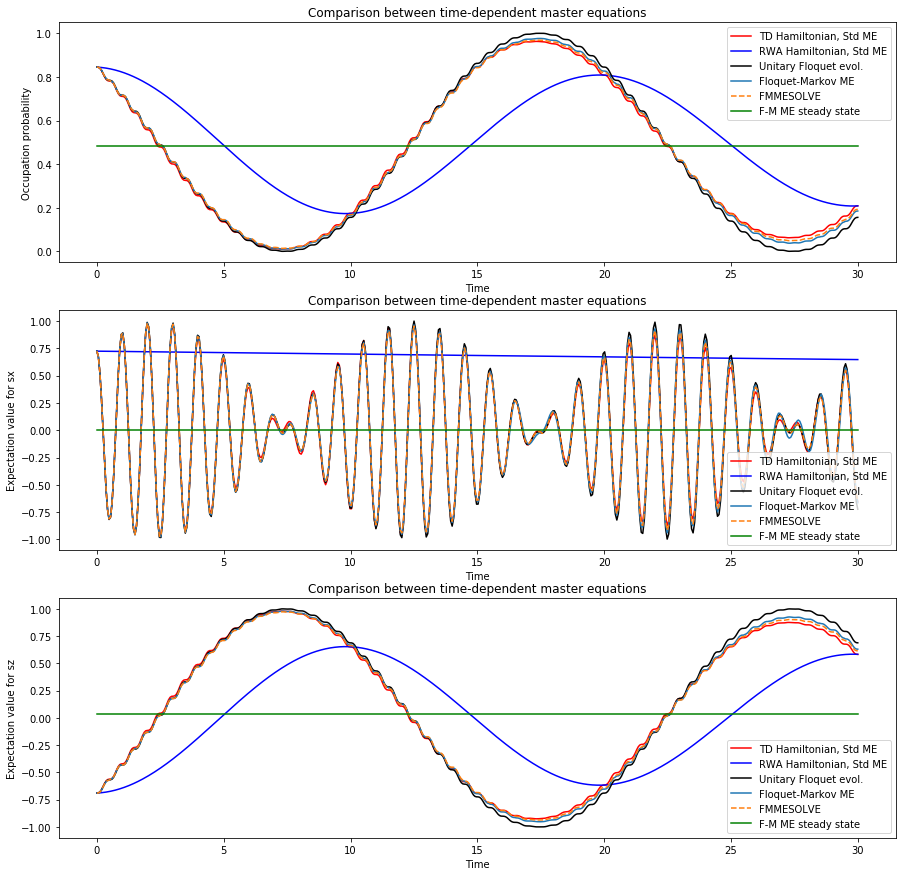

In [27]:
fig, ax = plt.subplots(3,1,figsize=(15,15))

label_y = ['Occupation probability','Expectation value for sx','Expectation value for sz']
for k in range(3):
    ax[k].plot(tlist, np.real(p_ex1[k]), 'r', tlist, np.real(p_ex2[k]), 'b-') # Lindblad ME
    ax[k].plot(tlist, np.real(p_ex3[k]), 'k', tlist, np.real(p_ex4[k]), 'C0-')# Floquet-Markov
    ax[k].plot(tlist, np.real(p_ex5[k]), 'C1--',tlist, np.real(p_ex6[k]), 'g-')

    ax[k].set_xlabel('Time')
    ax[k].set_ylabel(label_y[k])
    ax[k].set_title('Comparison between time-dependent master equations')
    ax[k].legend(("TD Hamiltonian, Std ME", "RWA Hamiltonian, Std ME", 
                  "Unitary Floquet evol.", "Floquet-Markov ME", 
                  "FMMESOLVE", "F-M ME steady state"));

## Floquet-Markov master equation

In [28]:
def J_cb(omega):
    """ Noise spectral density """
    return omega
    
def hamiltonian_t(t, args):
    """ evaluate the hamiltonian at time t. """
    H0 = args[0]
    H1 = args[1]
    w  = args[2]

    return H0 + np.cos(w * t) * H1

In [29]:
def qubit_integrate(delta, eps0, A, omega, psi0, tlist):

    # Hamiltonian
    sx = sigmax()
    sz = sigmaz()
    sm = destroy(2)

    H0 = - delta/2.0 * sx - eps0/2.0 * sz
    H1 =   A/2.0 * sz
        
    #H_args = (H0, H1, omega)
    H_args = {'w': omega}
    H = [H0, [H1, 'sin(w * t)']]
    
    # find the propagator for one driving period
    T = 2*np.pi / omega
       
    f_modes_0,f_energies = floquet_modes(H, T, H_args)

    c_op = sigmax()

    kmax = 1

    temp = 25e-3
    w_th = temp * (1.38e-23 / 6.626e-34) * 2 * np.pi * 1e-9
    
    Delta, X, Gamma, A = floquet_master_equation_rates(f_modes_0, f_energies, c_op, H, T, H_args, J_cb, w_th, kmax)

    k_idx = 0
    for k in range(-kmax,kmax+1, 1):
        print("X[",k,"] =\n", X[:,:,k_idx])
        k_idx += 1

    k_idx = 0
    for k in range(-kmax,kmax+1, 1):
        print("Delta[",k,"] =\n", Delta[:,:,k_idx])
        k_idx += 1

    k_idx = 0
    for k in range(-kmax,kmax+1, 1):
        print("Gamma[",k,"] =\n", Gamma[:,:,k_idx])
        k_idx += 1
        
    print("A =\n", A)

    rho_ss = floquet_master_equation_steadystate(H0, A)
    
    
    R = floquet_master_equation_tensor(A, f_energies)
    
    print("Floquet-Markov master equation tensor")
    
    print("R =\n", R)
    
    print("Floquet-Markov master equation steady state =\n", rho_ss)

    p_ex_0 = np.zeros(shape(tlist))
    p_ex_1 = np.zeros(shape(tlist))
    
    e_0 = np.zeros(shape(tlist))
    e_1 = np.zeros(shape(tlist))
        
    f_modes_table_t = floquet_modes_table(f_modes_0, f_energies, tlist, H, T, H_args) 
    for idx, t in enumerate(tlist):
        f_modes_t = floquet_modes_t_lookup(f_modes_table_t, t, T) 

        p_ex_0[idx] = expect(sm.dag() * sm, f_modes_t[0])
        p_ex_1[idx] = expect(sm.dag() * sm, f_modes_t[1])

        #evals = hamiltonian_t(t, H_args).eigenenergies()
        evals = qobj_list_evaluate(H, t, H_args).eigenenergies()
        e_0[idx] = min(np.real(evals))
        e_1[idx] = max(np.real(evals))
        
    return p_ex_0, p_ex_1, e_0, e_1, f_energies

In [30]:
delta = 0.2 * 2 * np.pi  # qubit sigma_x coefficient
eps0  = 1.0 * 2 * np.pi  # qubit sigma_z coefficient
A     = 2.5 * 2 * np.pi  # sweep rate
psi0   = basis(2,0)      # initial state
omega  = 1.0 * 2 * np.pi # driving frequency
T      = (2*np.pi)/omega # driving period

tlist = np.linspace(0.0, 1 * T, 101)

In [31]:
start_time = time.time()
p_ex_0, p_ex_1, e_0, e_1, f_e = qubit_integrate(delta, eps0, A, omega, psi0, tlist)
print('dynamics: time elapsed = ' + str(time.time() - start_time))

X[ -1 ] =
 [[-9.03801955e-07-0.19524686j  2.02821511e-01+0.31089132j]
 [-1.22745970e-03+0.00188092j  9.03801954e-07+0.19524686j]]
X[ 0 ] =
 [[-0.48721741-4.51028104e-19j  0.26340704-1.71842366e-01j]
 [ 0.26340704+1.71842366e-01j  0.48721741+1.82796486e-18j]]
X[ 1 ] =
 [[-9.03801955e-07+0.19524686j -1.22745970e-03-0.00188092j]
 [ 2.02821511e-01-0.31089132j  9.03801954e-07-0.19524686j]]
Delta[ -1 ] =
 [[ -6.28318531 -11.94580954]
 [ -0.62056108  -6.28318531]]
Delta[ 0 ] =
 [[ 0.         -5.66262423]
 [ 5.66262423  0.        ]]
Delta[ 1 ] =
 [[ 6.28318531  0.62056108]
 [11.94580954  6.28318531]]
Gamma[ -1 ] =
 [[-0. -0.]
 [-0. -0.]]
Gamma[ 0 ] =
 [[ 0.         -0.        ]
 [ 3.51925944  0.        ]]
Gamma[ 1 ] =
 [[1.50497000e+00 1.96690829e-05]
 [1.03422039e+01 1.50497000e+00]]
A =
 [[ 2.02170555  1.03320708]
 [14.89465076  2.02170555]]
Floquet-Markov master equation tensor
R =
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ -1.033207

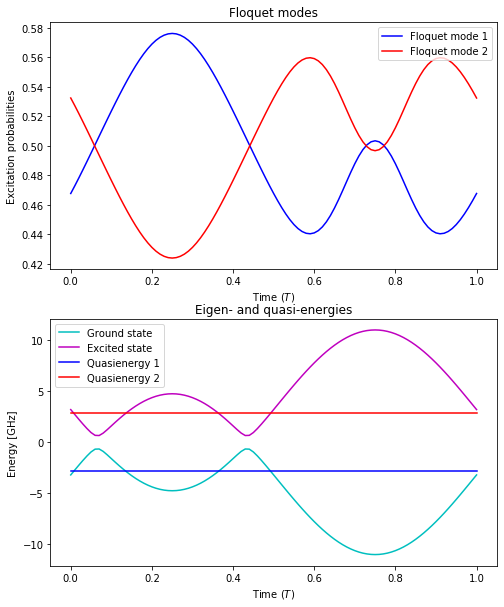

In [32]:
fig, axes = plt.subplots(2, 1, figsize=[8,10])

axes[0].plot(tlist, np.real(p_ex_0), 'b', tlist, np.real(p_ex_1), 'r')
axes[0].set_xlabel('Time ($T$)')
axes[0].set_ylabel('Excitation probabilities')
axes[0].set_title('Floquet modes')
axes[0].legend(("Floquet mode 1", "Floquet mode 2"))

axes[1].plot(tlist, np.real(e_0), 'c', tlist, np.real(e_1), 'm')
axes[1].plot(tlist, np.ones_like(tlist) * f_e[0], 'b', tlist, np.ones_like(tlist) * f_e[1], 'r')
axes[1].set_xlabel('Time ($T$)')
axes[1].set_ylabel('Energy [GHz]')
axes[1].set_title('Eigen- and quasi-energies')
axes[1].legend(("Ground state", "Excited state", "Quasienergy 1", "Quasienergy 2"));

## Floquet rates

The Floquet states and quasi-energies for a driven two-level system in the RWA can be calculated analytically for the Hamiltonian:

$H=\frac{\omega_q}{2}\sigma_z+A(e^{-i\omega_dt}\sigma_++e^{i\omega_dt}\sigma_-).$


In [33]:
def TLS_rates(wq, wd, tlist, gamma, params):
        """
        Compare rate transition and frequency transitions to analytical
        results for a driven two-level system, for different drive amplitudes.
        """

        sz = sigmaz()
        sx = sigmax()
        sp = sigmap()
        sm = sigmam()
        
        delta = wq - wd      # Detuning
        T = 2 * np.pi / wd
        
        H0 = wq/2 * sz
        arg = {'wd': wd}
        c_ops = sx
        
        # Analytical values of the quasi-energies
        array_ana_Em = [-np.sqrt((delta/2)**2 + a**2) for a in params]    # Energy of minus state |->
        array_ana_Ep = [np.sqrt((delta/2)**2 + a**2) for a in params]     # Energy of plus state  |+>
        array_ana_delta = [2*np.sqrt((delta/2)**2 + a**2) for a in params]

        X_ana = {'Xpp_p1': [],'Xpp_m1': [],'Xmm_p1': [],'Xmm_m1': [],
                  'Xpm_p1': [],'Xpm_m1': []}
        X_num = {}
        
        def J_cb(omega):
            if omega > 0:
                return 0.5 * gamma * omega/(2*np.pi)
            else:
                return 0

        idx = 0
        for a in params:
            # Hamiltonian
            H1_p = Qobj(a * sp)
            H1_m = Qobj(a * sm)
            H = [H0, [H1_p, lambda t, args: np.exp(-1j * arg['wd'] * t)],
                     [H1_m, lambda t, args: np.exp(1j * arg['wd'] * t)]]

            # Floquet modes
            fmodes0, fenergies = floquet_modes(H, T, args={}, sort=True)
            f_modes_table_t = floquet_modes_table(fmodes0, fenergies,
                                                  tlist, H, T,
                                                  args={})
            # Get X delta
            DeltaMatrix, X, frates, Amat = floquet_master_equation_rates(
                                            fmodes0, fenergies, c_ops, H, T,
                                            {}, J_cb, 0, 2)

            # Numerical Matrix elements
            Xs = np.ndarray.flatten(X)
            X_num['A'+str(round(a/(2*np.pi),3))] = Xs 
            
            # analytical Matrix elements
            normPlus = np.sqrt(a**2 + (array_ana_Ep[idx] - delta/2)**2)
            normMinus = np.sqrt(a**2 + (array_ana_Em[idx] - delta/2)**2)

            X_ana['Xpp_p1'].append((a/normPlus**2)*(array_ana_Ep[idx]-delta/2))    # Matrix element between states |+>, |+> and k=+1 
            X_ana['Xpp_m1'].append((a/normPlus**2)*(array_ana_Ep[idx]-delta/2))    # Matrix element between states |+>, |+> and k=-1
            X_ana['Xmm_p1'].append((a/normMinus**2)*(array_ana_Em[idx]-delta/2))   # Matrix element between states |->, |-> and k=+1
            X_ana['Xmm_m1'].append((a/normMinus**2)*(array_ana_Em[idx]-delta/2))   # Matrix element between states |->, |-> and k=-1
            X_ana['Xpm_p1'].append((a/(normMinus*normPlus))*(array_ana_Em[idx]-delta/2))  # Matrix element between states |+>, |-> and k=+1
            X_ana['Xpm_m1'].append((a/(normMinus*normPlus))*(array_ana_Ep[idx]-delta/2))  # Matrix element between states |+>, |-> and k=-1
            
            idx += 1
            
        return X_ana, X_num

In [34]:
# Parameters
wq = 5.4 * 2 * np.pi    # Qubit frequency
wd = 6.7 * 2 * np.pi    # Drive frequency
gamma = 0.15           # Relaxation rate
tlist = np.linspace(0.0, 2 * T, 101)    # Time list

param_A = np.linspace(0.001, 3 * 2 * np.pi, 10, endpoint=False)

X_ana, X_num = TLS_rates(wq, wd, tlist, gamma, param_A)

Notice that all matrix elements for $k\neq\pm 1$ are zero. 

/anaconda3/envs/qutip-env/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


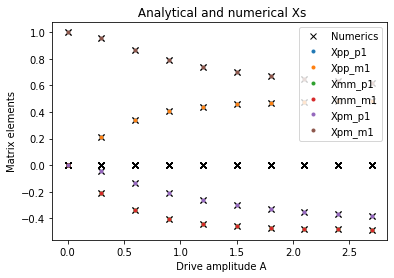

In [35]:
fig, ax = plt.subplots()

for a in param_A:
    if a==param_A[0]:
        ax.plot([a/(2*np.pi) for i in range(20)], X_num['A'+str(round(a/(2*np.pi),3))], 'kx', label='Numerics')
    else:
        ax.plot([a/(2*np.pi) for i in range(20)], X_num['A'+str(round(a/(2*np.pi),3))], 'kx')

idx = 0
for a in X_ana:
    ax.plot(param_A/(2*np.pi), X_ana[a], 'C'+str(idx)+'.',label= a)
    idx +=1

ax.set_ylabel('Matrix elements')
ax.set_xlabel(' Drive amplitude A')
ax.set_title(' Analytical and numerical Xs')
ax.legend(loc='upper right')

## Steadystate

In [36]:
def J_cb(omega):
    """ Noise spectral density """
    return omega
    
def hamiltonian_t(t, args):
    """ evaluate the hamiltonian at time t. """
    H0 = args['H0']
    H1 = args['H1']
    w  = args['w']

    return H0 + np.sin(w * t) * H1

def H1_coeff_t(t, args):
    return np.sin(args['w'] * t)

In [37]:
def qubit_integrate(delta, eps0_vec, A, omega, gamma1, gamma2, psi0, T, option):

    # Hamiltonian
    sx = sigmax()
    sz = sigmaz()
    sm = destroy(2)

    quasi_energies = np.zeros((len(eps0_vec), 2))
    f_gnd_prob     = np.zeros((len(eps0_vec), 2))
    wf_gnd_prob    = np.zeros((len(eps0_vec), 2))
    ss_prob1       = np.zeros(len(eps0_vec))
    ss_prob2       = np.zeros(len(eps0_vec))

    Hargs = {'w': omega}

    for idx, eps0 in enumerate(eps0_vec):

        H0 = - delta/2.0 * sx - eps0/2.0 * sz
        H1 = A/2.0 * sz
        H = [H0, [H1, 'sin(w * t)']]
            
        f_modes,f_energies = floquet_modes(H, T, Hargs)

        quasi_energies[idx,:] = f_energies

        f_gnd_prob[idx, 0] = expect(sm.dag() * sm, f_modes[0])
        f_gnd_prob[idx, 1] = expect(sm.dag() * sm, f_modes[1])

        f_states = floquet_states_t(f_modes, f_energies, 0, H, T, Hargs)

        wf_gnd_prob[idx, 0] = expect(sm.dag() * sm, f_states[0])
        wf_gnd_prob[idx, 1] = expect(sm.dag() * sm, f_states[1])

        c_op = sigmax()
        kmax = 5
        temp = 0e-3
        w_th = temp * (1.38e-23 / 6.626e-34) * 2 * np.pi * 1e-9    
        Delta, X, Gamma, Amat = floquet_master_equation_rates(f_modes, f_energies, c_op, H, T, Hargs, J_cb, w_th, kmax)

        rho_ss_fb = floquet_master_equation_steadystate(H0, Amat) # floquet basis
        rho_ss_cb = rho_ss_fb.transform(f_modes, True) #False           # computational basis
        
        ss_prob1[idx] = expect(sm.dag() * sm, rho_ss_fb)
        ss_prob2[idx] = expect(sm.dag() * sm, rho_ss_cb)

    return quasi_energies, f_gnd_prob, wf_gnd_prob, ss_prob1, ss_prob2

In [38]:
delta = 0.1 * 2 * np.pi  # qubit sigma_x coefficient
eps0  = 1.0 * 2 * np.pi  # qubit sigma_z coefficient
gamma1 = 0.0             # relaxation rate
gamma2 = 0.0             # dephasing  rate
A      = 2.0 * 2 * np.pi 
psi0   = basis(2,0)    # initial state
omega  = np.sqrt(delta**2 + eps0**2) # driving frequency
T      = (2*np.pi)/omega  # driving period

param  = np.linspace(-2.0, 2.0, 100) * 2 * np.pi 

eps0 = param

In [39]:
start_time = time.time()
q_energies, f_gnd_prob, wf_gnd_prob, ss_prob1, ss_prob2 = qubit_integrate(delta, eps0, A, omega, 
                                                                          gamma1, gamma2, psi0, T, "dynamics")
print('dynamics: time elapsed = ' + str(time.time() - start_time))

dynamics: time elapsed = 6.92350172996521


Text(0.5, 1.0, 'Floquet quasienergies')

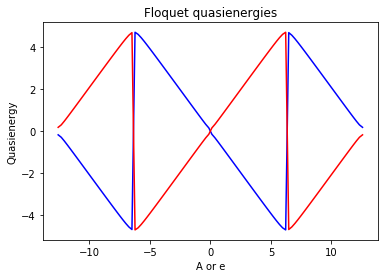

In [40]:
fig, ax = plt.subplots()
ax.plot(param, np.real(q_energies[:,0]) / delta, 'b',
        param, np.real(q_energies[:,1]) / delta, 'r')
ax.set_xlabel('A or e')
ax.set_ylabel('Quasienergy')
ax.set_title('Floquet quasienergies')

Text(0.5, 1.0, 'Floquet modes excitation probability')

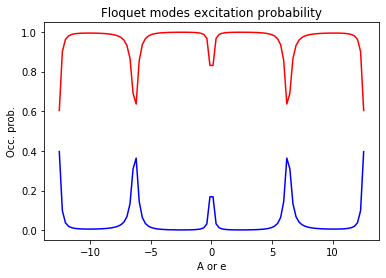

In [41]:
fig, ax = plt.subplots()
ax.plot(param, np.real(f_gnd_prob[:,0]), 'b',
        param, np.real(f_gnd_prob[:,1]), 'r')
ax.set_xlabel('A or e')
ax.set_ylabel('Occ. prob.')
ax.set_title('Floquet modes excitation probability')

Text(0.5, 1.0, 'Floquet states excitation probability')

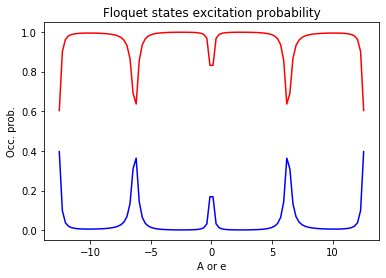

In [42]:
fig, ax = plt.subplots()
ax.plot(param, np.real(wf_gnd_prob[:,0]), 'b',
        param, np.real(wf_gnd_prob[:,1]), 'r')
ax.set_xlabel('A or e')
ax.set_ylabel('Occ. prob.')
ax.set_title('Floquet states excitation probability')

Text(0.5, 1.0, 'Steady state excitation probability')

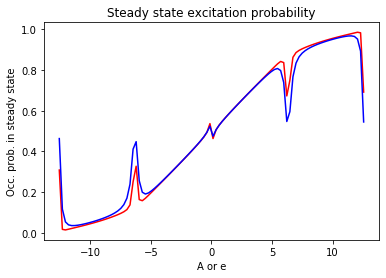

In [43]:
fig, ax = plt.subplots()
ax.plot(param, np.real(ss_prob1), 'r')
ax.plot(param, np.real(ss_prob2), 'b')
ax.set_xlabel('A or e')
ax.set_ylabel('Occ. prob. in steady state')
ax.set_title('Steady state excitation probability')

## Versions

In [44]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.4.0.dev0+8125c546
Numpy,1.16.4
SciPy,1.3.0
matplotlib,3.1.1
Cython,0.29.12
Number of CPUs,2
BLAS Info,OPENBLAS
IPython,7.9.0
Python,"3.7.5 (default, Oct 25 2019, 10:52:18) [Clang 4.0.1 (tags/RELEASE_401/final)]"
OS,posix [darwin]
